In [1]:
import numpy as np
np.random.seed(420)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 8]
sns.set_palette('viridis')

c:\Users\Kanan\OneDrive\Masaüstü\Asan\Xidmətdən imtinanın proqnozlaşdırılması\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading Function

In [2]:

def load_data():
    try:
        train_df = pd.read_csv('queue_dataset_train.csv')
        test_df = pd.read_csv('queue_dataset_test.csv')

        train_df = train_df.dropna(subset=['service_canceled']).reset_index(drop=True)

        for col in train_df.columns:
            if train_df[col].dtype == 'object':
                train_df[col].fillna('MISSING', inplace=True)
            else:
                train_df[col].fillna(train_df[col].median(), inplace=True)
                
        return train_df, test_df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

## Feature Engineering Class

In [3]:
class FeatureEngineer:
    def __init__(self):
        self.age_mean = None
        self.age_std = None
        self.service_coefs = None
        self.encoder = None
        
    def fix_ages(self, ages_raw):
        ages = []
        for row in tqdm(ages_raw, desc="Processing ages"):
            if isinstance(row, str) and '-' in row:
                try:
                    age = np.mean(list(map(int, row.split('-'))))
                except:
                    age = self.age_mean if self.age_mean is not None else 35
            else:
                try:
                    age = float(row)
                except:
                    age = self.age_mean if self.age_mean is not None else 35
            ages.append(age)
        
        ages = np.array(ages)
        if self.age_mean is None:
            self.age_mean = np.nanmean(ages)
        if self.age_std is None:
            self.age_std = np.nanstd(ages)
        
        ages = np.nan_to_num(ages, nan=self.age_mean)
        return (ages - self.age_mean) / self.age_std
    
    def fix_time(self, times_raw):
        times = []
        for t in tqdm(times_raw, desc="Processing times"):
            if not isinstance(t, str) or pd.isna(t):
                t = "12:00:00.0"
            try:
                parts = t.split(":")
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(float(parts[2]))  # Handle decimal seconds
                times.append(hours * 3600 + minutes * 60 + seconds)
            except:
                times.append(43200)  # Default to noon
        return np.array(times) / 86400
    
    def process_dates(self, df):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['weekday'] = df['date'].dt.weekday
        df['day'] = df['date'].dt.day
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['day_of_year'] = df['date'].dt.dayofyear
        df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
        df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
        df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
        return df
    
    def calculate_service_popularity(self, df):
        service_cols = ['service_name_organization', 'service_name', 'service_name_2']
        if self.service_coefs is None:
            self.service_coefs = {}
            for col in service_cols:
                value_counts = df[col].value_counts(normalize=True)
                self.service_coefs[col] = value_counts.to_dict()
        
        for col in service_cols:
            df[f'{col}_popularity'] = df[col].map(self.service_coefs[col])
        df['popularity_coeff'] = df[[f'{col}_popularity' for col in service_cols]].prod(axis=1)
        return df
    
    def add_interaction_features(self, df):
        df['age_time_interaction'] = df['customer_age_appl'] * df['time_start_process']
        df['operator_load'] = df['previous_customer_count'] / (df['operator_count'] + 1e-5)
        df['wait_time_estimate'] = df['previous_customer_count'] * df['time_start_process']
        return df
    
    def encode_categoricals(self, train_df, test_df, target_col):
        cat_cols = ['branch_name', 'customer_gender', 'customer_city',
                   'service_name_organization', 'service_name', 'service_name_2']
        self.encoder = TargetEncoder(cols=cat_cols)
        train_df[cat_cols] = self.encoder.fit_transform(train_df[cat_cols], train_df[target_col])
        test_df[cat_cols] = self.encoder.transform(test_df[cat_cols])
        
        return train_df, test_df

## Data Preprocessing Function

In [4]:

def preprocess_data(train_df, test_df):
    fe = FeatureEngineer()

    train_df = fe.process_dates(train_df)
    test_df = fe.process_dates(test_df)

    train_df, test_df = fe.encode_categoricals(train_df, test_df, 'service_canceled')

    train_df['customer_age_appl'] = fe.fix_ages(train_df['customer_age_appl'])
    test_df['customer_age_appl'] = fe.fix_ages(test_df['customer_age_appl'])

    train_df['time_start_process'] = fe.fix_time(train_df['time_start_process'])
    test_df['time_start_process'] = fe.fix_time(test_df['time_start_process'])

    train_df = fe.calculate_service_popularity(train_df)
    test_df = fe.calculate_service_popularity(test_df)

    train_df = fe.add_interaction_features(train_df)
    test_df = fe.add_interaction_features(test_df)

    train_cols = train_df.columns
    test_cols = test_df.columns
    
    for col in set(train_cols) - set(test_cols):
        test_df[col] = 0
    for col in set(test_cols) - set(train_cols):
        train_df[col] = 0
    
    return train_df, test_df

## Feature Selection Function

In [5]:
# Feature Selection
def select_features(X, y, k=50):
    selector = SelectKBest(f_classif, k=min(k, X.shape[1]))
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    return selected_features

## Hyperparameter Optimization

In [6]:
# Hyperparameter Optimization
def optimize_hyperparameters(X, y):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 15),
            'random_state': 420,
            'verbosity': -1
        }
        
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=420)
        scores = []
        
        for trn_idx, val_idx in skf.split(X, y):
            X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]
            
            # Handle class imbalance
            smote = SMOTE(sampling_strategy=0.5, random_state=420)
            rus = RandomUnderSampler(sampling_strategy=0.7, random_state=420)
            pipeline = imbpipeline(steps=[('smote', smote), ('rus', rus)])
            X_tr, y_tr = pipeline.fit_resample(X_tr, y_tr)
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_tr, y_tr)
            
            val_preds = model.predict_proba(X_val)[:, 1]
            score = roc_auc_score(y_val, val_preds)
            scores.append(score)
        
        return np.mean(scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, timeout=3600)  # 1 hour timeout
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  AUC: {trial.value:.5f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return trial.params

## Ensemble Model Class

In [7]:
# Ensemble Model Training
class EnsembleModel:
    def __init__(self, lgb_params, n_folds=5):
        self.lgb_params = lgb_params
        self.n_folds = n_folds
        self.models = []
        self.feature_importances = None
        
    def train(self, X, y, X_test):
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=420)
        lgb_preds = np.zeros(X_test.shape[0])
        xgb_preds = np.zeros(X_test.shape[0])
        cat_preds = np.zeros(X_test.shape[0])
        oof_preds = np.zeros(X.shape[0])
        feature_importance = np.zeros(X.shape[1])
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"\nFold {fold + 1}/{self.n_folds}")
            X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]
            
            # Handle class imbalance
            smote = SMOTE(sampling_strategy=0.5, random_state=420)
            rus = RandomUnderSampler(sampling_strategy=0.7, random_state=420)
            pipeline = imbpipeline(steps=[('smote', smote), ('rus', rus)])
            X_tr, y_tr = pipeline.fit_resample(X_tr, y_tr)
            
            # LightGBM
            lgb_model = lgb.LGBMClassifier(**self.lgb_params)
            lgb_model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='auc',
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=False),
                    lgb.log_evaluation(50)
                ]
            )
            lgb_val_preds = lgb_model.predict_proba(X_val)[:, 1]
            lgb_preds += lgb_model.predict_proba(X_test)[:, 1] / self.n_folds
            feature_importance += lgb_model.feature_importances_ / self.n_folds
            
            # XGBoost
            xgb_model = xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='auc',
                learning_rate=0.05,
                max_depth=6,
                n_estimators=200,
                scale_pos_weight=12,
                random_state=420,
                tree_method='hist'  # Faster training
            )
            xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            xgb_val_preds = xgb_model.predict_proba(X_val)[:, 1]
            xgb_preds += xgb_model.predict_proba(X_test)[:, 1] / self.n_folds
            
            # CatBoost
            cat_model = CatBoostClassifier(
                iterations=500,
                learning_rate=0.05,
                depth=6,
                scale_pos_weight=12,
                random_seed=420,
                verbose=0,
                task_type='GPU'
            )
            cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
            cat_val_preds = cat_model.predict_proba(X_val)[:, 1]
            cat_preds += cat_model.predict_proba(X_test)[:, 1] / self.n_folds
            
            # Blend predictions
            blend_val_preds = (lgb_val_preds*0.4 + xgb_val_preds*0.3 + cat_val_preds*0.3)
            oof_preds[val_idx] = blend_val_preds
            
            # Metrics
            fold_auc = roc_auc_score(y_val, blend_val_preds)
            precision, recall, _ = precision_recall_curve(y_val, blend_val_preds)
            pr_auc = auc(recall, precision)
            print(f"Fold {fold + 1} ROC-AUC: {fold_auc:.5f}")
        
        # Final predictions with weighted blending
        final_preds = (lgb_preds*0.5 + xgb_preds*0.3 + cat_preds*0.2)
        overall_auc = roc_auc_score(y, oof_preds)
        
        # Feature importance
        self.feature_importances = pd.DataFrame({
            'feature': X.columns,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        print(f"\nOverall OOF ROC-AUC: {overall_auc:.5f}")
        print("\nTop 10 Features:")
        print(self.feature_importances.head(10))
        
        return final_preds, overall_auc

## Main Execution

Processing times: 100%|██████████| 364162/364162 [00:00<00:00, 995729.43it/s]



Training ensemble model...

Fold 1/5
[50]	valid_0's auc: 0.700704
[100]	valid_0's auc: 0.712632
Fold 1 ROC-AUC: 0.71942

Fold 2/5
[50]	valid_0's auc: 0.703124
[100]	valid_0's auc: 0.713988
Fold 2 ROC-AUC: 0.72070

Fold 3/5
[50]	valid_0's auc: 0.703152
[100]	valid_0's auc: 0.713994
Fold 3 ROC-AUC: 0.72086

Fold 4/5
[50]	valid_0's auc: 0.701307
[100]	valid_0's auc: 0.712161
Fold 4 ROC-AUC: 0.71892

Fold 5/5
[50]	valid_0's auc: 0.703384
[100]	valid_0's auc: 0.714639
Fold 5 ROC-AUC: 0.72118

Overall OOF ROC-AUC: 0.72021

Top 10 Features:
                      feature  importance
0                 branch_name       977.2
3               customer_city       854.6
2           customer_age_appl       541.6
5                service_name       498.4
19    service_name_popularity       375.8
9     previous_customer_count       343.2
21           popularity_coeff       311.0
1             customer_gender       268.2
6              service_name_2       260.8
20  service_name_2_popularity       251

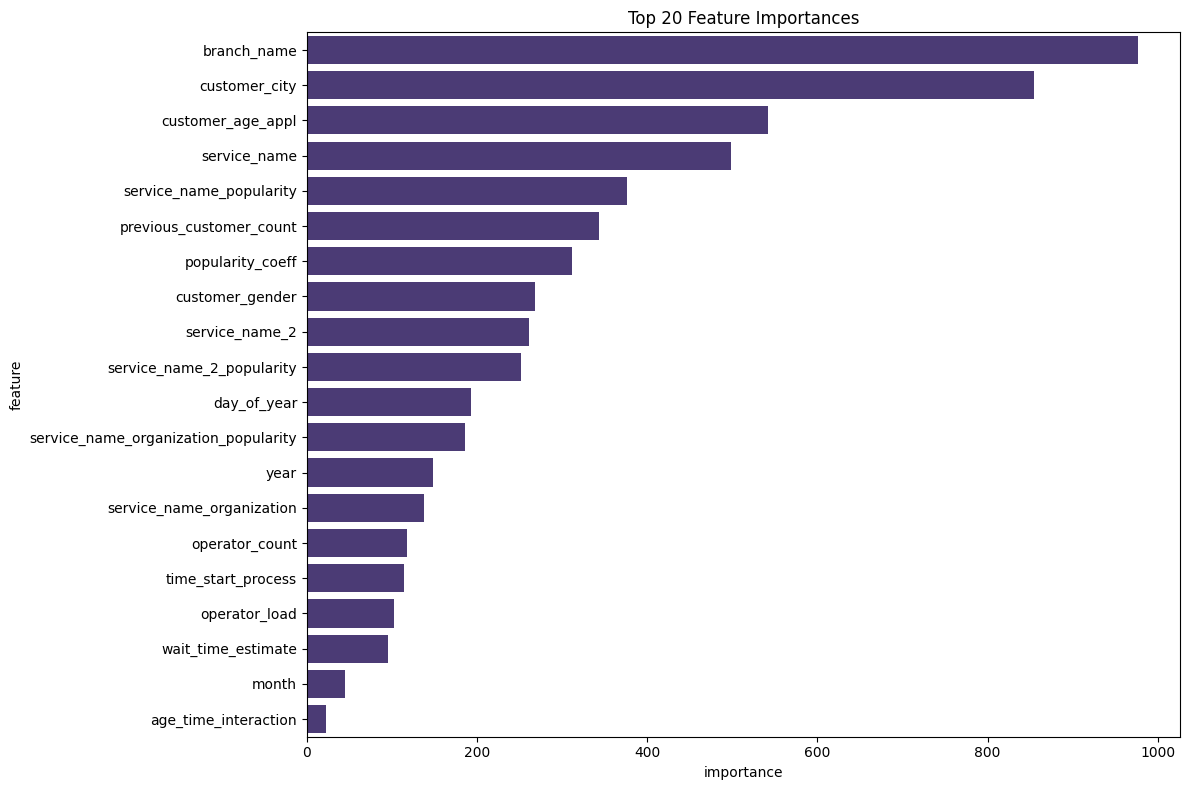

In [8]:
train_df, test_df = load_data()

train_df, test_df = preprocess_data(train_df, test_df)

drop_cols = ['id', 'date', 'service_canceled']
X = train_df.drop(drop_cols, axis=1)
y = train_df['service_canceled']
X_test = test_df.drop([col for col in drop_cols if col in test_df.columns], axis=1)

selected_features = select_features(X, y, k=50)
X = X[selected_features]
X_test = X_test[selected_features]

# Optimize hyperparameters (uncomment to run)
# print("Optimizing hyperparameters...")
# best_params = optimize_hyperparameters(X, y)
# print("Optimized parameters:", best_params)

best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 60,
    'max_depth': 7,
    'min_child_samples': 30,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 12,
    'random_state': 420,
    'verbosity': -1
}

print("\nTraining ensemble model...")
ensemble = EnsembleModel(best_params, n_folds=5)
test_predictions, model_score = ensemble.train(X, y, X_test)
print(f"Model score: {model_score:.5f}")

submission = pd.DataFrame({
    'id': test_df['id'],
    'service_canceled': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file saved!")

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', 
            data=ensemble.feature_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()